In [533]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from funciones import SOM, Oja
from collections import defaultdict
#from minisom import MiniSom # for comparison l42
from sklearn.decomposition import PCA

### Load and format data

In [534]:
# Load dataset with specified data types
dtypes = {'Country': 'str', 
          'Area': 'int64', 
          'GDP': 'int64', 
          'Inflation': 'float64', 
          'Life.expect': 'float64', 
          'Military': 'float64', 
          'Pop.growth': 'float64', 
          'Unemployment': 'float64'}

df = pd.read_csv('europe.csv', dtype=dtypes)

# Separate country names since it's not numerical
country_names = df['Country']
df_numeric = df.drop('Country', axis=1)

# Normalize numerical data
df_numeric = (df_numeric - df_numeric.mean()) / df_numeric.std()

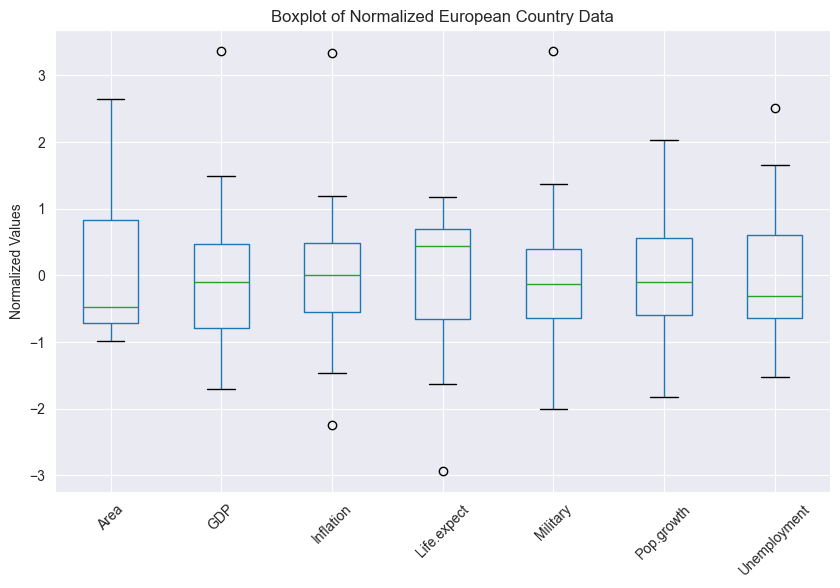

In [535]:
# Boxplot of normalized data
plt.figure(figsize=(10, 6))
df_numeric.boxplot()
plt.title('Boxplot of Normalized European Country Data')
plt.ylabel('Normalized Values')
plt.xticks(range(1, len(df_numeric.columns) + 1), df_numeric.columns, rotation=45)
plt.show()

# 1.1 Red de Kohonen

### Self-Organizing Map (SOM) / Kohonen map

In [536]:
# Define SOM parameters
x = 5  # Width of map
y = 5  # Height of map
input_len = df_numeric.shape[1]  # Number of features in data
sigma = 1.0 # Neighbourhood radius
learning_rate = 0.5

# Create SOM
som = SOM(x, y, input_len, sigma, learning_rate) # create SOM
som.random_weights_init(df_numeric.values) # initial random weights

# Train SOM
iterations = 10000
som.train_random(df_numeric.values, iterations)

### Unified Distance Matrix  (U-Matrix)

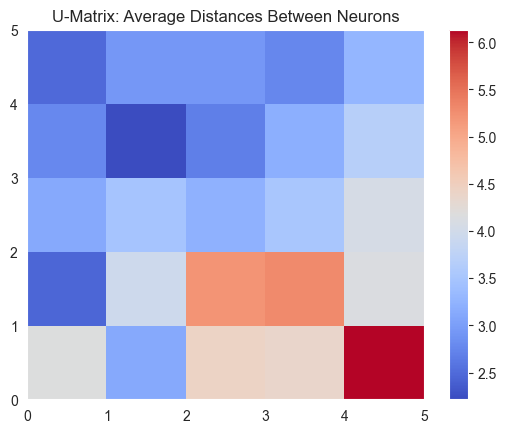

In [537]:
# Plot U-Matrix of the SOM
plt.pcolor(som.distance_map().T, cmap='coolwarm') # https://matplotlib.org/stable/gallery/color/colormap_reference.html
plt.colorbar()
plt.title('U-Matrix: Average Distances Between Neurons')
plt.show()

### Winning neuron. Elements assigned to each neuron

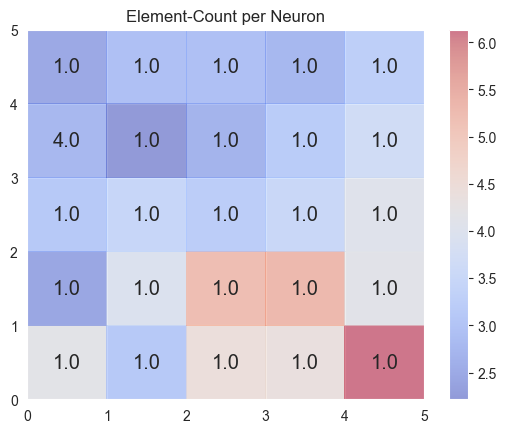

In [538]:
# Calculate element counts for each neuron
neuron_counts = defaultdict(int)
winning_countries = defaultdict(list)

for i, sample in enumerate(df_numeric.values):
    winning_neuron = som.winner(sample)
    neuron_counts[winning_neuron] += 1
    winning_countries[winning_neuron].append(country_names.iloc[i])

# Reshape counts into grid, handling potential dead neurons
counts_grid = np.zeros((x, y))  # Initialize to zeros
for coordinates, count in neuron_counts.items():
    x_coord, y_coord = coordinates
    counts_grid[y_coord][x_coord] = count

# Initialize plot
fig, ax = plt.subplots()

# Plot the U-Matrix/SOM grid (to put count on)
plt.pcolor(som.distance_map().T, cmap='coolwarm', alpha=0.5)

# Overlay count labels on neurons
for x in range(som.get_weights().shape[0]):
    for y in range(som.get_weights().shape[1]):
        ax.text(x + 0.5, y + 0.5, str(counts_grid[y][x]),
                ha='center', va='center', size='x-large')

ax.set_title('Element-Count per Neuron')
plt.colorbar()
plt.show()

### Categorization of countries

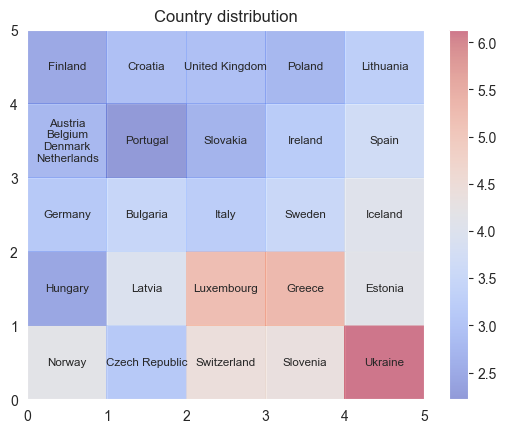

In [539]:
# Initialize plot
fig, ax = plt.subplots()

# Plot the U-Matrix/SOM grid (to put countries on)
plt.pcolor(som.distance_map().T, cmap='coolwarm', alpha=0.5)

# Overlay countries on each neuron
for x in range(som.get_weights().shape[0]):
    for y in range(som.get_weights().shape[1]):
        countries = winning_countries.get((x, y), [])
        if countries:
            country_text = "\n".join(countries)  # Join with newlines
            ax.text(x + 0.5, y + 0.5, country_text, ha='center', va='center', size='small', wrap=True)
ax.set_title('Country distribution')
plt.colorbar()
plt.show()

# Ejercicio 1.2 - Modelo de Oja

### Modelo de Oja

In [540]:
# Oja's Rule
oja_input_len = df_numeric.shape[1]
oja_learning_rate = 0.01
iterations = 10000

oja = Oja(oja_input_len, oja_learning_rate)
oja.train(df_numeric.values, iterations)

# Get the first principal component from Oja's rule
oja_weights = oja.get_weights()

### PC1 coefficients of attributes

In [541]:
# Create a dictionary to associate features with coefficients
feature_names = df_numeric.columns
feature_coef_dict = dict(zip(feature_names, oja_weights))

# Sort the dictionary by coefficient values high to low
sorted_features_oja = sorted(feature_coef_dict.items(), key=lambda item: item[1], reverse=True)

# Print PC1 coefficients along with their respective features in sorted order
print("\nPC1 coefficients of attributes:")
for feature, coefficient in sorted_features_oja:
    print(f"{feature}: {coefficient:.2f}")


PC1 coefficients of attributes:
Life.expect: 0.50
GDP: 0.49
Pop.growth: 0.46
Military: -0.13
Area: -0.20
Unemployment: -0.23
Inflation: -0.48


### Barplot of PC1 coefficients of attributes (Oja's Rule)

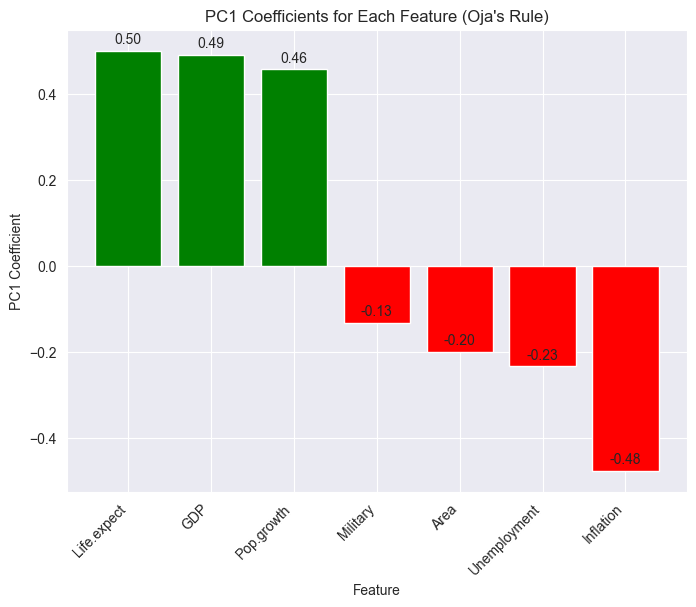

In [542]:
# Define colors based on coefficient values
colors = ['green' if coef >= 0 else 'red' for _, coef in sorted_features_oja]

# Bar plot of coefficient of PC1
plt.figure(figsize=(8, 6))
bars = plt.bar([feature for feature, _ in sorted_features_oja], [coef for _, coef in sorted_features_oja], color=colors)
plt.xlabel('Feature')
plt.ylabel('PC1 Coefficient')
plt.title('PC1 Coefficients for Each Feature (Oja\'s Rule)')
plt.xticks(rotation=45, ha="right")

# Add labels to the bars
for bar in bars:
    height = bar.get_height()
    label_text = f'{height:.2f}'  # Format the label text
    plt.annotate(label_text,
                 xy=(bar.get_x() + bar.get_width() / 2, height),
                 xytext=(0, 3),  # 3 points vertical offset
                 textcoords="offset points",
                 ha='center', va='bottom')

plt.show()

### PC1 score of countries

In [543]:
# Project data onto the first principal component
pc1_scores = df_numeric.dot(oja_weights)

# Create a DataFrame to associate country names with PC1 scores
result_df = pd.DataFrame({'Country': country_names, 'PC1': pc1_scores})
result_df_sorted_oja = result_df.sort_values(by='PC1', ascending=False) # sort results high to low PC1 score

# Print unsorted country PC1 score
#print("\nPC1 score of countries:")
#print(result_df)

# Print sorted results of PC1 score
print("\nPC1 value of countries:")
for index, row in result_df_sorted_oja.iterrows():
    print(f"{row['Country']}: {row['PC1']:.2f}")


PC1 value of countries:
Luxembourg: 3.34
Switzerland: 3.32
Norway: 2.06
Netherlands: 1.87
Ireland: 1.81
Iceland: 1.41
Austria: 1.00
Denmark: 0.96
Italy: 0.81
Sweden: 0.74
Belgium: 0.69
Germany: 0.52
United Kingdom: 0.29
Czech Republic: 0.24
Finland: 0.15
Slovenia: 0.11
Spain: 0.09
Portugal: -0.42
Greece: -0.70
Slovakia: -0.76
Croatia: -1.02
Hungary: -1.35
Lithuania: -1.49
Poland: -1.51
Latvia: -2.28
Estonia: -2.41
Bulgaria: -2.49
Ukraine: -4.97


### Bar plot of countries PC1 score (Oja's Rule)

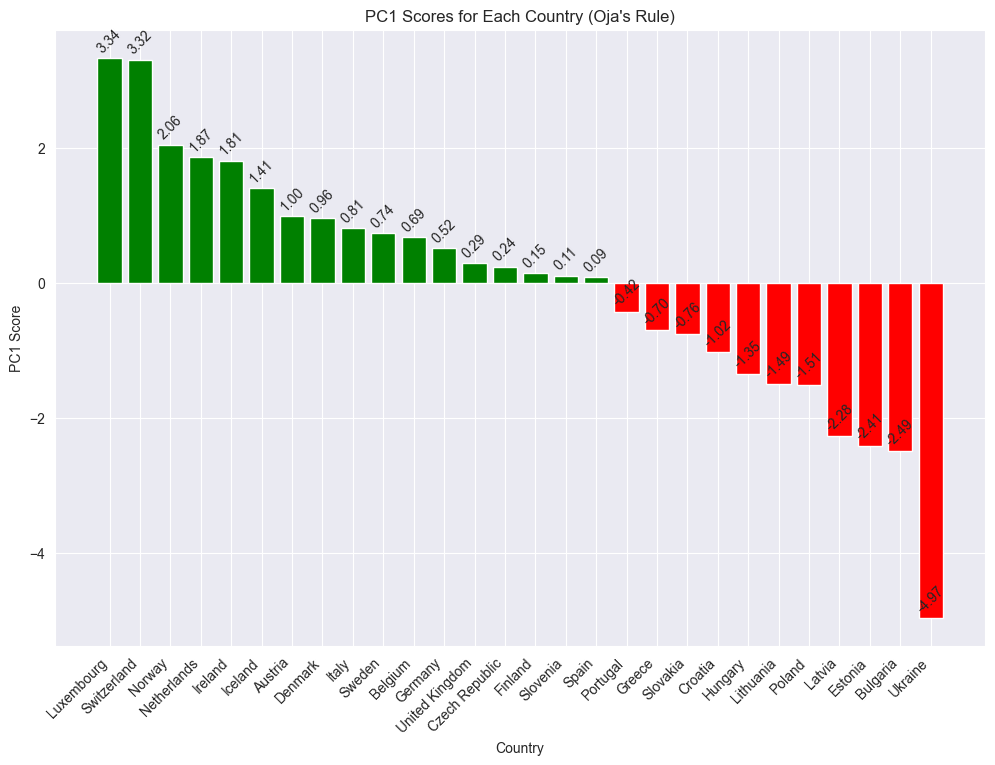

In [544]:
# Define colors based on PC1 values
colors = ['green' if pc1 >= 0 else 'red' for pc1 in result_df_sorted_oja['PC1']]

# Bar plot of countries' PC1 score
plt.figure(figsize=(12, 8))  
bars = plt.bar(result_df_sorted_oja['Country'], result_df_sorted_oja['PC1'], color=colors)
plt.xlabel('Country')
plt.ylabel('PC1 Score')
plt.title('PC1 Scores for Each Country (Oja\'s Rule)')
plt.xticks(rotation=45, ha='right')

# Add PC1 value labels to the bars
for bar in bars:
    height = bar.get_height()
    label_text = f'{height:.2f}' 
    plt.annotate(label_text,
                 xy=(bar.get_x() + bar.get_width() / 2, height),
                 xytext=(0, 2),  
                 textcoords="offset points",
                 ha='center', va='bottom', rotation=45)

plt.show()

### PCA with SciKit Learn to compare results

In [545]:
# Perform PCA using scikit-learn
pca = PCA(n_components=1)
pca.fit(df_numeric)

# Get the first principal component
first_pc = pca.components_[0]

# Create a dictionary to associate features with coefficients
feature_coef_dict = dict(zip(df_numeric.columns, first_pc))

# Sort the dictionary by coefficient values in descending order
sorted_features_sklearn = sorted(feature_coef_dict.items(), key=lambda item: item[1], reverse=True)

# Print PC1 coefficients along with their respective features in sorted order
print("\nPC1 coefficients of attributes (w. sklearn):")
for feature, coefficient in sorted_features_sklearn:
    print(f"{feature}: {coefficient:.2f}")



PC1 coefficients of attributes (w. sklearn):
Inflation: 0.41
Unemployment: 0.27
Military: 0.19
Area: 0.12
Pop.growth: -0.48
Life.expect: -0.48
GDP: -0.50


### Bar plot of PC1 coefficients w. SciKit Learn

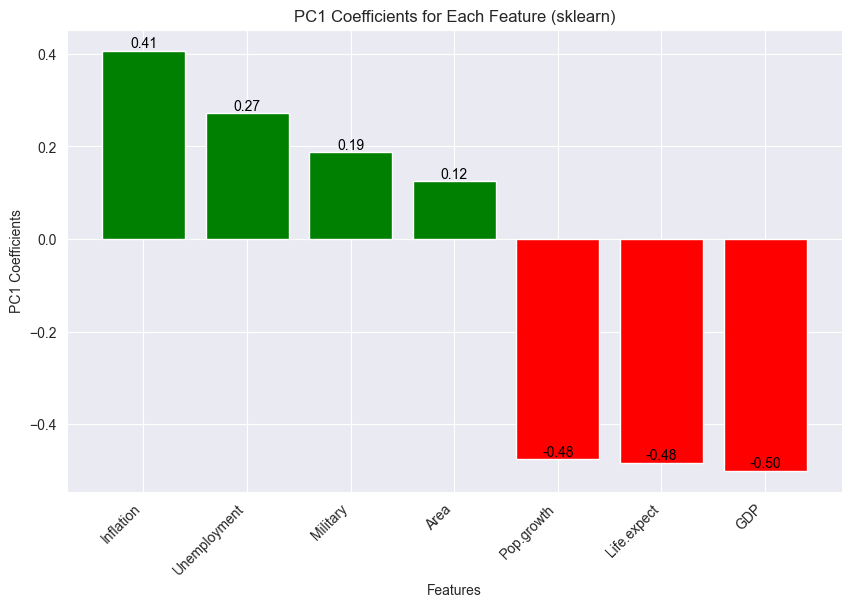

In [546]:
# Set up colors for positive and negative values (after sorting)
colors = ["red" if coef < 0 else "green" for _, coef in sorted_features_sklearn]  

# Bar plot of coefficients - sklearn (using sorted features)
plt.figure(figsize=(10, 6))
bars = plt.bar([feature for feature, _ in sorted_features_sklearn], [coef for _, coef in sorted_features_sklearn], color=colors)
plt.xlabel("Features")
plt.ylabel("PC1 Coefficients")
plt.title("PC1 Coefficients for Each Feature (sklearn)")
plt.xticks(rotation=45, ha='right')

# Add labels to each bar (using sorted features)
for bar in bars:
    height = bar.get_height()
    label_color = "black"
    plt.text(bar.get_x() + bar.get_width() / 2, height, f"{height:.2f}", ha='center', va='bottom', color=label_color)
plt.show()

In [547]:
# Project the data onto the principal component
pc1_scores = pca.transform(df_numeric)

# Combine countries and their PC1 scores into a DataFrame
result_df = pd.DataFrame({'Country': country_names, 'PC1': pc1_scores.squeeze()})  # squeeze() converts to 1D array

# Sort by PC1 in descending order
result_df_sorted_sklearn = result_df.sort_values(by='PC1', ascending=False)

# Print the sorted PC1 scores for each country
print("\nPC1 value of countries (with library):")
for index, row in result_df_sorted_sklearn.iterrows():
    print(f"{row['Country']}: {row['PC1']:.2f}")


PC1 value of countries (with library):
Ukraine: 4.50
Bulgaria: 2.56
Estonia: 2.44
Latvia: 2.26
Lithuania: 1.50
Poland: 1.45
Hungary: 1.37
Croatia: 1.25
Greece: 0.98
Slovakia: 0.77
Portugal: 0.52
Slovenia: 0.07
Spain: -0.16
Czech Republic: -0.16
Finland: -0.21
United Kingdom: -0.33
Germany: -0.58
Belgium: -0.67
Italy: -0.84
Sweden: -0.87
Denmark: -0.94
Austria: -1.06
Iceland: -1.56
Ireland: -1.78
Netherlands: -1.81
Norway: -2.07
Switzerland: -3.22
Luxembourg: -3.42


### Barplot of country PC1 score (w. SciKit Learn)

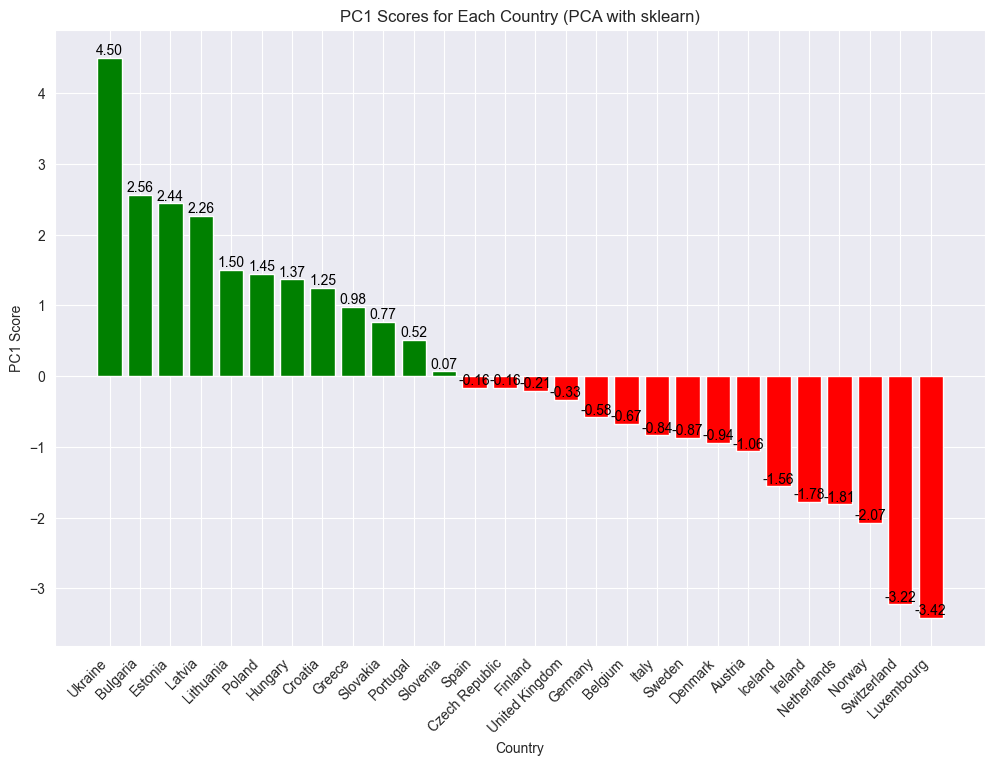

In [548]:
# Set up colors for positive and negative values
colors = ["green" if pc1 >= 0 else "red" for pc1 in result_df_sorted_sklearn["PC1"]]

# Create bar plot
plt.figure(figsize=(12, 8))
bars = plt.bar(result_df_sorted_sklearn["Country"], result_df_sorted_sklearn["PC1"], color=colors)
plt.xlabel("Country")
plt.ylabel("PC1 Score")
plt.title("PC1 Scores for Each Country (PCA with sklearn)")
plt.xticks(rotation=45, ha="right")

# Add labels to the bars
for bar in bars:
    height = bar.get_height()
    label_color = "black"  # Choose label color for visibility
    plt.text(bar.get_x() + bar.get_width() / 2, height, f"{height:.2f}", ha="center", va="bottom", color=label_color)

plt.show()

### PC1 score of countries together (kinda useless with inverted values :)))

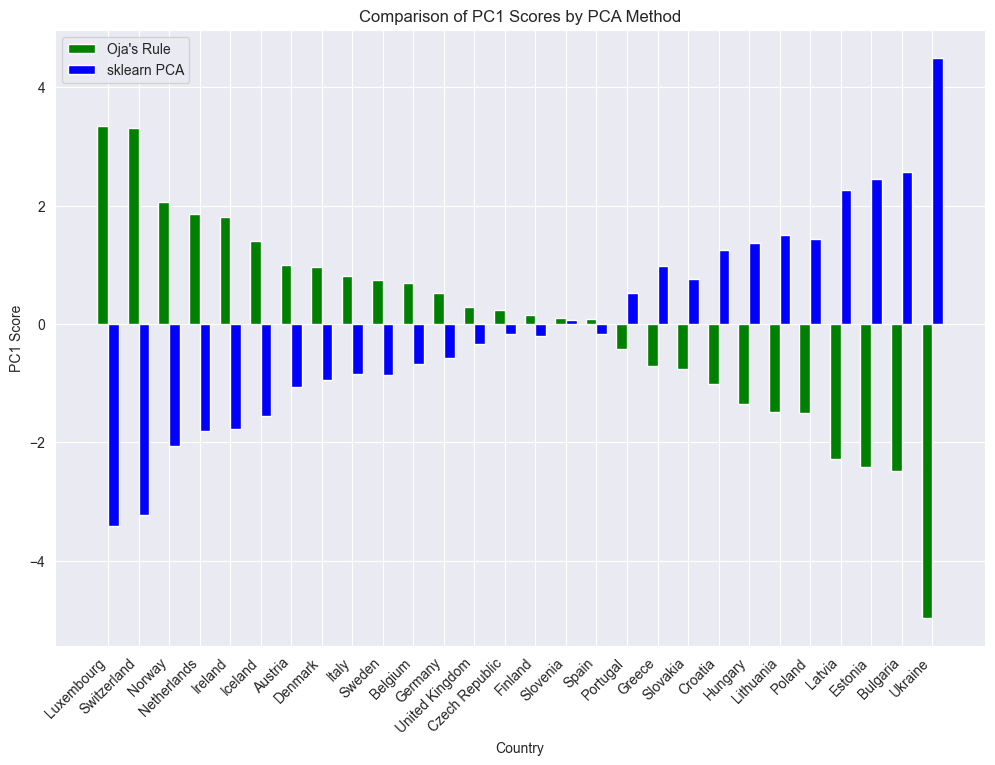

In [549]:
combined_df = pd.merge(result_df_sorted_oja, result_df_sorted_sklearn, on="Country", suffixes=("_oja", "_sklearn"))

bar_width = 0.35
x_positions_oja = range(len(combined_df))
x_positions_sklearn = [x + bar_width for x in x_positions_oja]

plt.figure(figsize=(12, 8))
plt.bar(x_positions_oja, combined_df['PC1_oja'], color='green', width=bar_width, label='Oja\'s Rule')
plt.bar(x_positions_sklearn, combined_df['PC1_sklearn'], color='blue', width=bar_width, label='sklearn PCA')

# Add labels, title, and legend
plt.xlabel('Country')
plt.ylabel('PC1 Score')
plt.title('Comparison of PC1 Scores by PCA Method')
plt.xticks([r + bar_width / 2 for r in range(len(combined_df))], combined_df['Country'], rotation=45, ha='right')
plt.legend()

plt.show()